In [1]:
import pandas as pd
import numpy as np
from tqdm.notebook import trange
import matplotlib.pyplot as plt

import cv2
from skimage.util import img_as_float
from skimage import color
from sklearn.cluster import KMeans

In [2]:
def get_image(path):
    img = cv2.imread(path,cv2.IMREAD_COLOR)
    return img_as_float(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [3]:
from typing import Tuple

def segmentate(
    image: np.ndarray, 
    distance_between_centroids: int = 16,
    coordinates_bounding: bool = True
) -> Tuple[np.ndarray]:
    height = image.shape[0]
    width = image.shape[1]
    channels = image.shape[2]
    
    # convert RGB to Lab
    lab = color.rgb2lab(image)
    features = lab.reshape(height * width, channels)  # 3D array to 2D array
    
    # add XY coordinate feature so the clusters are coordinates-bounded
    if coordinates_bounding:
        x_coordinate = np.tile(np.arange(width), height).reshape(-1, 1)
        y_coordinate = np.tile(np.arange(height).reshape(-1, 1), width).reshape(-1, 1)
        features = np.concatenate([features, x_coordinate, y_coordinate], 1)
    
    # initial centroids coordinates
    centroids = []
    for i in range(distance_between_centroids, height, distance_between_centroids):
        for j in range(distance_between_centroids, width, distance_between_centroids):
            centroids.append(features[width * i + j, :])

    # get clusters
    kmeans = KMeans(
        n_clusters=len(centroids), 
        init=centroids, 
        random_state=42, 
        n_init=1
    )
    kmeans.fit(features)
    
    labels = np.reshape(kmeans.labels_, (height, width))
    centroids = kmeans.cluster_centers_
    return labels, centroids

In [4]:
def contour_mask(array: np.ndarray) -> np.ndarray:
    # create shifted arrays
    shifted_right = np.roll(array, shift=-1, axis=1)
    shifted_down = np.roll(array, shift=-1, axis=0)

    # compare shifted arrays with the original one, thus finding contours
    horizontal_diff = array[:, :-1] != shifted_right[:, :-1]
    vertical_diff = array[:-1, :] != shifted_down[:-1, :]

    # add missing row and column
    horizontal_diff = np.hstack((horizontal_diff, np.zeros((array.shape[0], 1), dtype=bool)))
    vertical_diff = np.vstack((vertical_diff, np.zeros((1, array.shape[1]), dtype=bool)))

    contour_mask = np.logical_or(horizontal_diff, vertical_diff)
    return contour_mask

In [5]:
def draw_contours(
    image: np.ndarray,
    labels: np.ndarray
) -> np.ndarray:
    mask = contour_mask(labels)
    image = np.copy(image)
    
    # black contours
    for channel in range(image.shape[2]):
        image[:, :, channel][mask] = 0
    return image

In [6]:
import os
from pathlib import Path

project_dir = Path(os.environ['PROJECT_DIR'])
image_path = project_dir / 'data/artworks/portrait.jpg'
image = get_image(image_path.as_posix())
image = image[300:556, 300:556, :]  # crop to 256x256

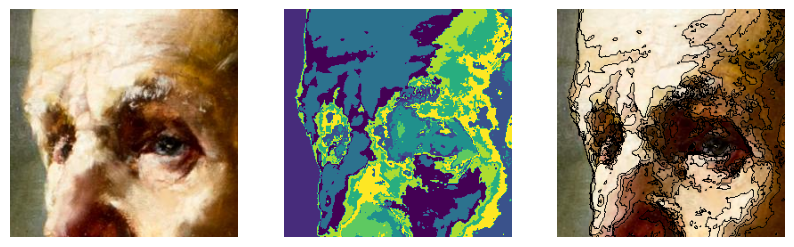

In [7]:
labels, _ = segmentate(
    image=image,
    distance_between_centroids=80,
    coordinates_bounding=False
)

fig, ax = plt.subplots(1, 3, figsize=(10, 6))

ax[0].imshow(image)
ax[0].axis("off")

ax[1].imshow(labels)
ax[1].axis("off")

ax[2].imshow(draw_contours(image, labels))
ax[2].axis("off")

plt.show()

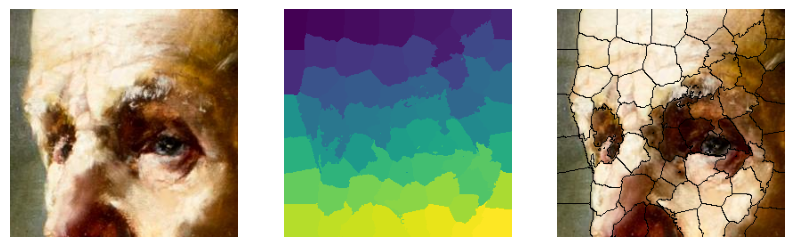

In [8]:
labels, _ = segmentate(
    image=image,
    distance_between_centroids=30,
    coordinates_bounding=True
)

fig, ax = plt.subplots(1, 3, figsize=(10, 6))

ax[0].imshow(image)
ax[0].axis("off")

ax[1].imshow(labels)
ax[1].axis("off")

ax[2].imshow(draw_contours(image, labels))
ax[2].axis("off")

plt.show()